# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [2]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
#%pip install pandas==2.1.4
#%pip install lightgbm==4.4.0
#pip install optuna==3.6.1

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 10.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time
from kaggle.api.kaggle_api_extended import KaggleApi
import pickle

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
base_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'
dataset_file2 = 'competencia_01_DQ.csv'

data = pd.read_csv(dataset_path + dataset_file)
data_DQ = pd.read_csv(dataset_path + dataset_file2)

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202103
mes_test = 202104

# agregue sus semillas
semillas = [540079, 250829, 314299, 302111, 801007]


C:\Users\Federico\AppData\Local\Temp\ipykernel_432\2942254696.py:9: DtypeWarning: Columns (97) have mixed types. Specify dtype option on import or set low_memory=False.
  data_DQ = pd.read_csv(dataset_path + dataset_file2)


In [9]:
df=data.copy()
df.shape
df2=data_DQ.copy()
df2.shape

(981946, 98)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [10]:
df['clase_peso'] = 1.0
df2['clase_peso'] = 1.0

In [11]:
df['clase_binaria'] = 0
df['clase_binaria'] = np.where(df['clase_ternaria'] == 'CONTINUA', 0, 1)

df.loc[df['clase_binaria'] == 1, 'clase_peso'] = 1.0001

#### para df_DQ

df2['clase_binaria'] = 0
df2['clase_binaria'] = np.where(df2['clase_ternaria'] == 'CONTINUA', 0, 1)

df2.loc[df2['clase_binaria'] == 1, 'clase_peso'] = 1.0001

# Modelos

Armo 2 modelos:
- M1: Todas las variables 
- M2: 124 variables (Data Quality)


## Para filtrar el df variando las variables segun importancia

In [278]:
# dataset_path = base_path + 'datasets/'
# dataset_file = 'top_N_features_lgbm_v2.csv'
# n_features= pd.read_csv(dataset_path + dataset_file)
# top_N_features_lgbm_v2_list=n_features["feature"].to_list()

In [279]:
# # Lista de columnas adicionales que quieres incluir
# columnas_adicionales = ["foto_mes",'clase_ternaria', 'clase_peso', 'clase_binaria']

# # Unificar las dos listas de columnas
# columnas_finales = top_N_features_lgbm_v2_list + columnas_adicionales

# # Filtrar el dataframe utilizando las columnas finales
# df = df[columnas_finales]

In [280]:
# df.shape

(981946, 74)

In [12]:
## funciones generales
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.0001, ganancia_acierto, 0) - np.where(weight < 1.0001, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True


Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

## M1

In [13]:
## M1 todas las variables
train_data = df[df['foto_mes'] == mes_train]
test_data = df[df['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_train_binaria = train_data['clase_binaria']
w_train = train_data['clase_peso']

X_test_m1 = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test_binaria_m1 = test_data['clase_binaria']
w_test_m1 = test_data['clase_peso']

In [14]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 100, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 500, 4000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.3, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.3, 1.0)

    params = {
        'objective': 'binary',
        'metric': 'custom',
        #'boosting_type': 'rf',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'early_stopping_rounds': int(50 + 5 / learning_rate),
        'verbose': -1
    }

    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria, # todos los baja como 1
                              weight=w_train)
    
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=10000, # modificar, subit y subir
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimizacion_LGBM_Compe_01.db"
study_name = "optimizacion_lgbm_M1"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-07 23:57:12,605] A new study created in RDB with name: optimizacion_lgbm_M1


In [15]:
#nombre=optimizacion_lgbm_M1
study.optimize(objective, n_trials=50) # subir subir

[I 2024-10-07 23:57:56,164] Trial 0 finished with value: 315392000.0 and parameters: {'num_leaves': 128, 'learning_rate': 0.09943638666048686, 'min_data_in_leaf': 3982, 'feature_fraction': 0.6665959439149192, 'bagging_fraction': 0.819895573465218}. Best is trial 0 with value: 315392000.0.
[I 2024-10-07 23:58:08,221] Trial 1 finished with value: 312872000.0 and parameters: {'num_leaves': 133, 'learning_rate': 0.12943834665094361, 'min_data_in_leaf': 3107, 'feature_fraction': 0.9883021527441276, 'bagging_fraction': 0.6346910395655903}. Best is trial 0 with value: 315392000.0.
[I 2024-10-07 23:58:27,984] Trial 2 finished with value: 316463000.0 and parameters: {'num_leaves': 199, 'learning_rate': 0.11444507107528641, 'min_data_in_leaf': 2973, 'feature_fraction': 0.5957646367048024, 'bagging_fraction': 0.805981119619265}. Best is trial 2 with value: 316463000.0.
[I 2024-10-07 23:58:42,420] Trial 3 finished with value: 305081000.0 and parameters: {'num_leaves': 288, 'learning_rate': 0.17267

KeyboardInterrupt: 

Analizamos los resultados as usual

In [16]:
optuna.visualization.plot_optimization_history(study)

In [17]:
plot_param_importances(study)

In [18]:
plot_slice(study)

In [19]:
study.best_trial

FrozenTrial(number=10, state=1, values=[319347000.0], datetime_start=datetime.datetime(2024, 10, 8, 0, 0, 8, 989859), datetime_complete=datetime.datetime(2024, 10, 8, 0, 0, 45, 191228), params={'num_leaves': 227, 'learning_rate': 0.05021072005244666, 'min_data_in_leaf': 3866, 'feature_fraction': 0.8398778300071111, 'bagging_fraction': 0.3009153444557738}, user_attrs={'best_iter': 376}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=300, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=4000, log=False, low=500, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None)}, trial_id=11, value=None)

In [20]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria,
                          weight=w_train)

model_lgb = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [21]:
### salvamos el modelo
model_lgb.save_model(modelos_path + 'lgbm_M1.txt')

Observamos la variables más importantes para el modelo:

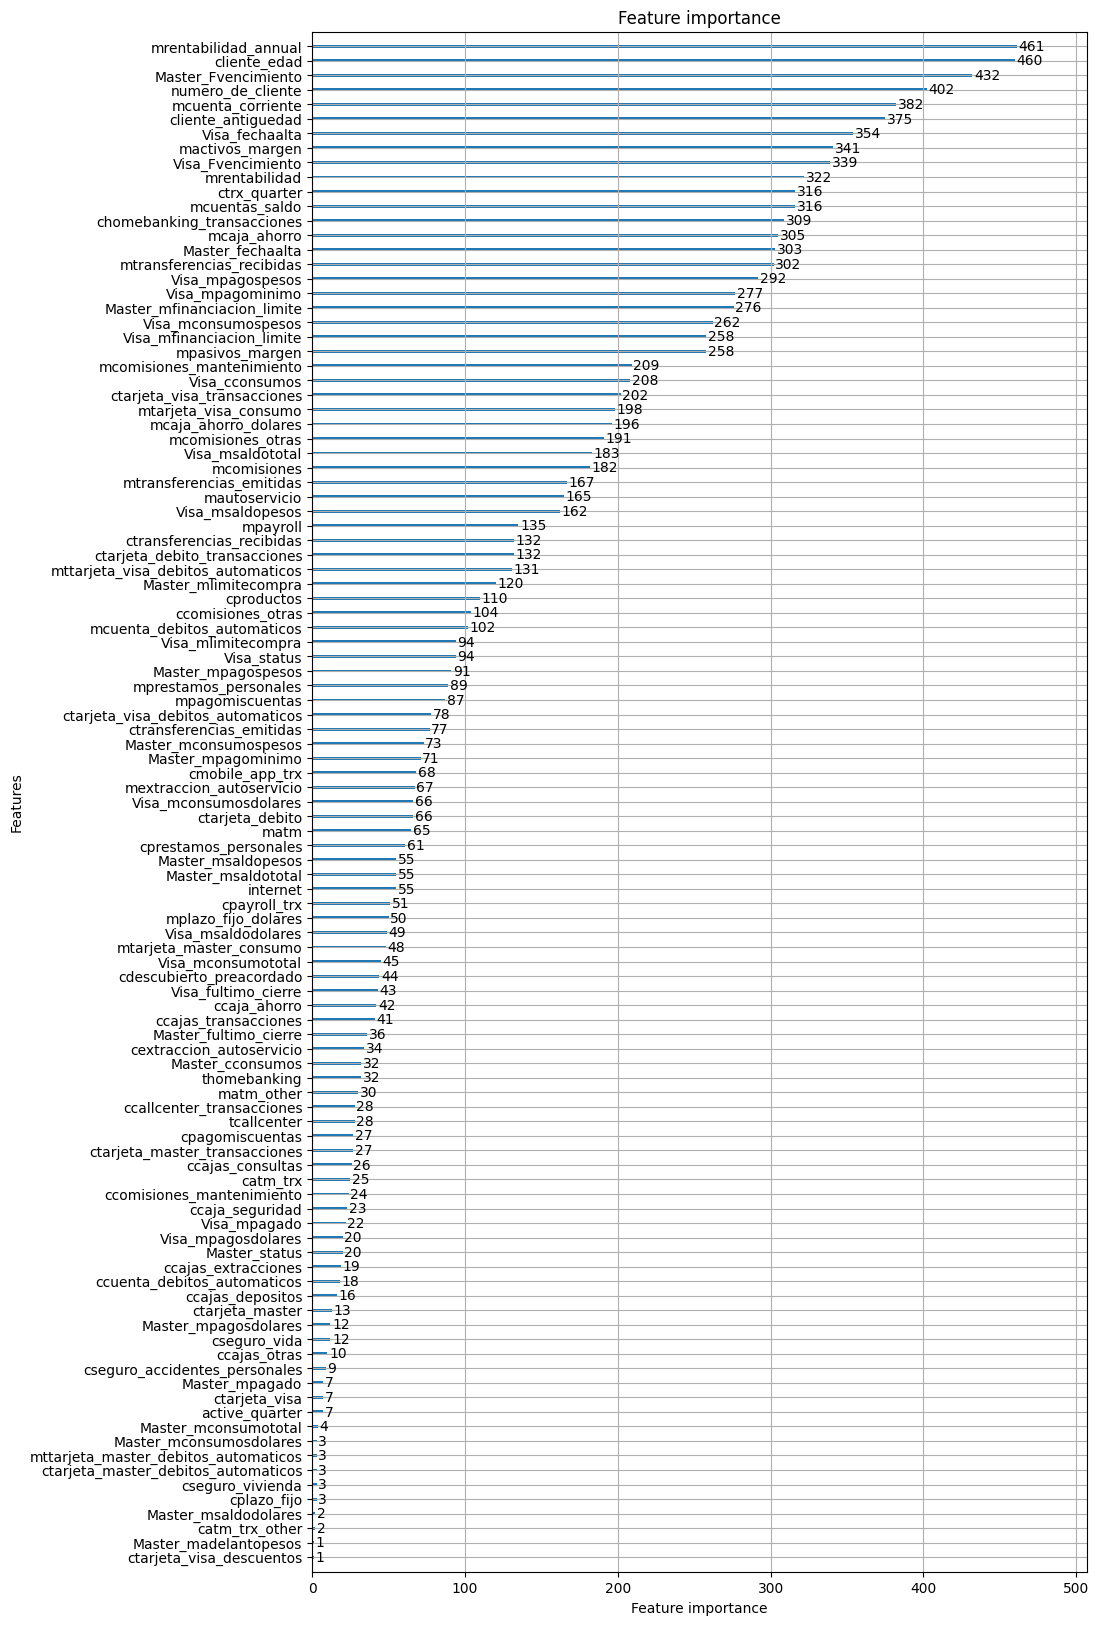

In [22]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [23]:
importances = model_lgb.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 1]


,feature,importance
8,mrentabilidad_annual,461
5,cliente_edad,460
113,Master_Fvencimiento,432
0,numero_de_cliente,402
16,mcuenta_corriente,382
...,...,...
60,mttarjeta_master_debitos_automaticos,3
59,ctarjeta_master_debitos_automaticos,3
119,Master_mconsumosdolares,3
105,catm_trx_other,2


## M2, optimizacion mismos pasos

In [24]:
## M2 algunas variables
train_data = df2[df2['foto_mes'] == mes_train]
test_data = df2[df2['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_train_binaria = train_data['clase_binaria']
w_train = train_data['clase_peso']

X_test_m2 = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test_binaria_m2 = test_data['clase_binaria']
w_test_m2 = test_data['clase_peso']

In [25]:
storage_name = "sqlite:///" + db_path + "optimizacion_LGBM_Compe_01.db"
study_name = "optimizacion_lgbm_M2"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-08 00:03:27,372] A new study created in RDB with name: optimizacion_lgbm_M2


In [26]:
study.optimize(objective, n_trials=50) # subir subir

[I 2024-10-08 00:03:53,354] Trial 0 finished with value: 298165000.0 and parameters: {'num_leaves': 290, 'learning_rate': 0.11544157294557228, 'min_data_in_leaf': 1154, 'feature_fraction': 0.5829411472173782, 'bagging_fraction': 0.5908126782640928}. Best is trial 0 with value: 298165000.0.
[I 2024-10-08 00:04:04,218] Trial 1 finished with value: 301455000.0 and parameters: {'num_leaves': 232, 'learning_rate': 0.12250115306785425, 'min_data_in_leaf': 3206, 'feature_fraction': 0.5953977970693282, 'bagging_fraction': 0.6429113618043918}. Best is trial 1 with value: 301455000.0.
[I 2024-10-08 00:04:18,621] Trial 2 finished with value: 300734000.0 and parameters: {'num_leaves': 218, 'learning_rate': 0.11696211898972221, 'min_data_in_leaf': 1132, 'feature_fraction': 0.4193809239328897, 'bagging_fraction': 0.48116590361605693}. Best is trial 1 with value: 301455000.0.
[I 2024-10-08 00:04:28,513] Trial 3 finished with value: 296842000.0 and parameters: {'num_leaves': 262, 'learning_rate': 0.18

KeyboardInterrupt: 

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
plot_param_importances(study)

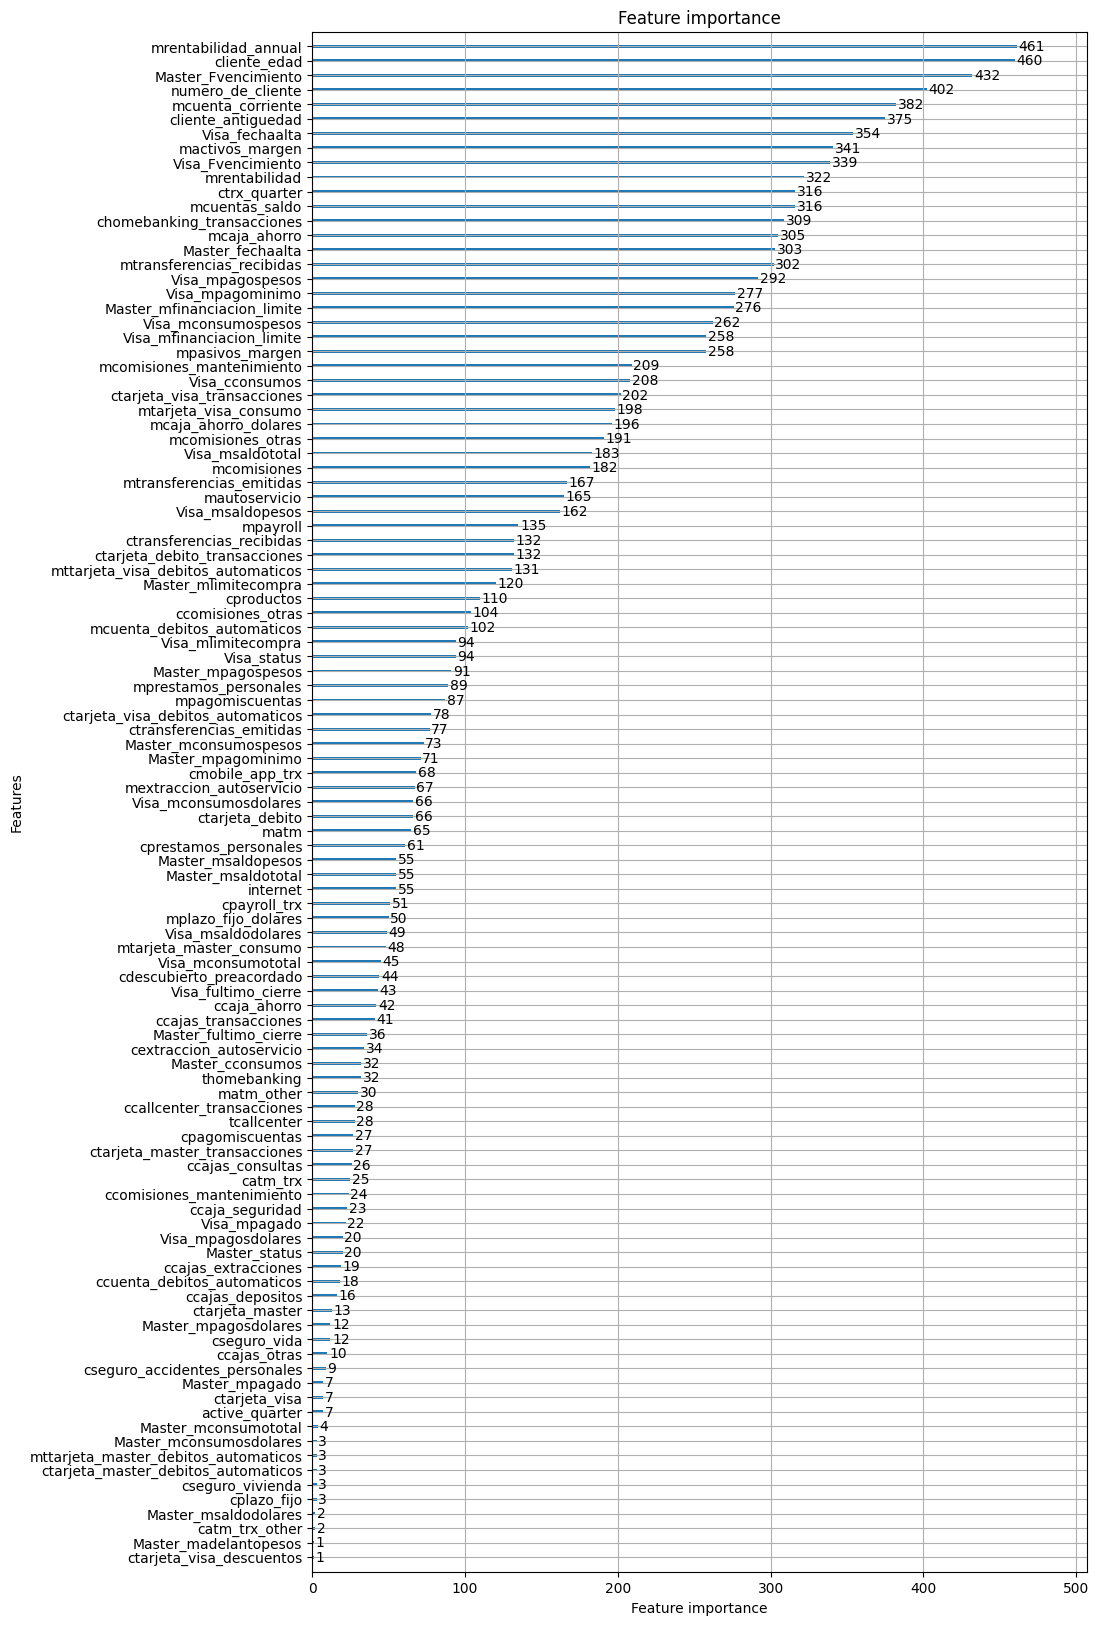

In [29]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()


In [30]:
study.best_trial

FrozenTrial(number=11, state=1, values=[307076000.0], datetime_start=datetime.datetime(2024, 10, 8, 0, 6, 29, 72216), datetime_complete=datetime.datetime(2024, 10, 8, 0, 6, 52, 80620), params={'num_leaves': 166, 'learning_rate': 0.050616667260534404, 'min_data_in_leaf': 1983, 'feature_fraction': 0.7635546438529444, 'bagging_fraction': 0.7685288410493712}, user_attrs={'best_iter': 147}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=300, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=4000, log=False, low=500, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None)}, trial_id=27, value=None)

In [31]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria,
                          weight=w_train)

model_lgb = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [32]:
### salvamos el modelo
model_lgb.save_model(modelos_path + 'lgbm_M2.txt')

In [33]:
## levantamos los modelos 
M1 = lgb.Booster(model_file=modelos_path + 'lgbm_M1.txt')
M2 = lgb.Booster(model_file=modelos_path + 'lgbm_M2.txt')

In [34]:
# predecimos sobre Xtest(cambia en cada caso, tengo que volver a correr)
y_pred_lgm_M1 = M1.predict(X_test_m1)

In [35]:
y_pred_lgm_M2 = M2.predict(X_test_m2)

In [36]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia M1:", ganancia_prob(y_pred_lgm_M1, y_test_binaria_m1))
print("Ganancia M2:", ganancia_prob(y_pred_lgm_M2, y_test_binaria_m2))


Ganancia M1: 379988000.0
Ganancia M2: 370531000.0


## Publico/Privado

In [37]:
#Lo tengo que hacer por separado por que tengo distinto N de columnas
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"M1":y_pred_lgm_M1}
rows = []
for private_index, public_index in sss_futuro.split(X_test_m1, y_test_binaria_m1):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_test_binaria_m1.iloc[public_index], 0.3)
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_test_binaria_m1.iloc[private_index], 0.7)
  rows.append(row)
df_lb = pd.DataFrame(rows)

In [38]:
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

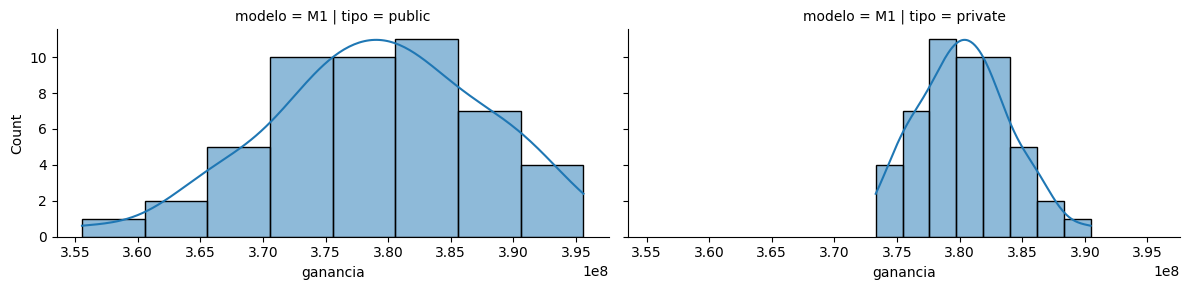

In [39]:
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()

In [40]:
## voy con M2
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"M2":y_pred_lgm_M2}
rows = []
for private_index, public_index in sss_futuro.split(X_test_m2, y_test_binaria_m2):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_test_binaria_m2.iloc[public_index], 0.3)
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_test_binaria_m2.iloc[private_index], 0.7)
  rows.append(row)
df_lb = pd.DataFrame(rows)

In [41]:
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

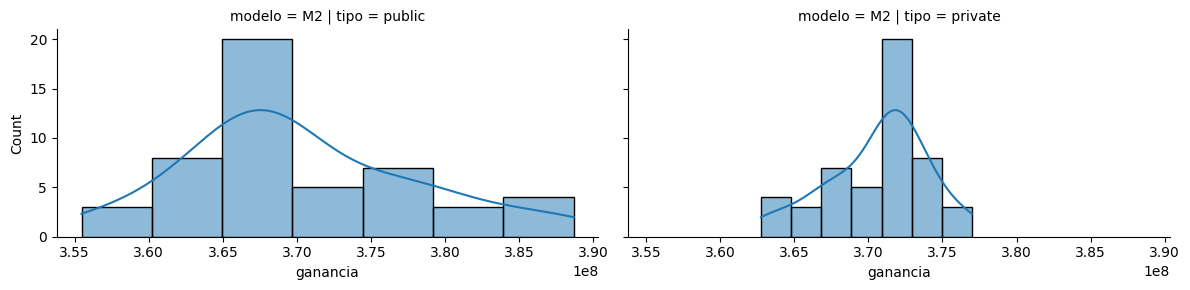

In [42]:
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()

Decido quedarme con el modelo 2